<a href="https://colab.research.google.com/github/kenchin138/DA-and-DS-Projects/blob/main/Google_Play_Store_Analysis/Google_Play_Store_App_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Environment

In [25]:
pip install -U kaleido

In [3]:
pip install plotly==5.16

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [1]:
import pandas as pd
import plotly.io as pio
import plotly.express as px
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
pwd = os.getcwd()
pio.renderers.default = "svg"

# Loading Dataset

The dataset contains 10,841 entries and 13 features in total.

In [3]:
data = pd.read_csv(pwd + '/googleplaystore.csv', encoding='unicode_escape')

In [ ]:
data.sample(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver
2736,Candy Crush Saga,GAME,4.40,22428456,74,"500,000,000+",Free,0,Everyone,Casual,5-Jul-18,1.129.0.2,4.1 and up
2201,Shadow Fight 2,GAME,4.60,10981850,88,"100,000,000+",Free,0,Everyone 10+,Action,2-Jul-18,1.9.38,3.0 and up
8038,Blood Donor,MEDICAL,4.20,4476,20,"500,000+",Free,0,Everyone,Medical,31-Jul-18,1.6.2,4.1 and up
104,Who,COMMUNICATION,4.30,2451093,NaN,"100,000,000+",Free,0,Teen,Communication,3-Aug-18,Varies with device,Varies with device
10269,MegaNDS (NDS Emulator),GAME,3.40,2218,11,"500,000+",Free,0,Everyone,Arcade,18-Oct-17,2,4.0 and up
8253,Stickman and Axe,GAME,4.40,69,2.8,"50,000+",Free,0,Teen,Action,25-Nov-17,1,4.0.3 and up
9311,EGW Writings 2,BOOKS_AND_REFERENCE,4.70,6547,16,"100,000+",Free,0,Everyone,Books & Reference,8-Dec-17,4.0.3,4.0.3 and up
6172,EP Gem Hunter,GAME,4.60,79,31,"1,000+",Free,0,Everyone 10+,Action,17-Jan-16,1.1.0,2.3 and up
126,True Contact - Real Caller ID,COMMUNICATION,4.10,32283,NaN,"1,000,000+",Free,0,Everyone,Communication,26-Jul-18,Varies with device,Varies with device
3164,Where's My Water?,FAMILY,4.70,188740,69,"1,000,000+",Paid,1.99,Everyone,Puzzle;Brain Games,5-Jul-18,1.16.0,4.2 and up


In [ ]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content_Rating     object
Genres             object
Last_Updated       object
Current_Ver        object
Android_Ver        object
dtype: object

In [ ]:
data.shape

(10841, 13)

# Data Preprocessing

## Dropping Unused Columns
Since `Last_Updated`, `Current_Ver`, and `Android_Ver` are not relevant to the analysis, they will be dropped.

In [4]:
data_cleaned = data.copy()
data_cleaned.drop(['Last_Updated', 'Current_Ver', 'Android_Ver'], axis=1, inplace=True)

##Formatting Values

In [5]:
data_cleaned['Category'].replace({'_':' ', 'AND':'&'}, regex=True, inplace=True)
data_cleaned['Category'] = data_cleaned['Category'].str.title()
data_cleaned['Installs'].replace({'\+':'', ',':''}, regex=True, inplace=True)
data_cleaned.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
0,Floor Plan Creator,Art & Design,4.10,36639,NaN,5000000,Free,0,Everyone,Art & Design
1,Textgram - write on photos,Art & Design,4.40,295221,NaN,10000000,Free,0,Everyone,Art & Design
2,Used Cars and Trucks for Sale,Auto & Vehicles,4.60,17057,NaN,1000000,Free,0,Everyone,Auto & Vehicles
3,Ulysse Speedometer,Auto & Vehicles,4.30,40211,NaN,5000000,Free,0,Everyone,Auto & Vehicles
4,REPUVE,Auto & Vehicles,3.90,356,NaN,100000,Free,0,Everyone,Auto & Vehicles


## Checking Inconsistencies

`Rating` is the only feature that has a numerical data type while `Reviews`, `Size`, `Installs`, and `Price` should also be numerical. These features may contain strings that should be removed.

`Rating` also has an outlier of 19 when ratings should only go up to 5.

`Type` should have only two categories, `free` and `paid`. However, there are three categories.

Further investigation reveals that a single row with missing data in `Category` caused its values to shift to the left. Removing this row resolves the above errors.

Although the data type and `Rating` outliers are resolved, the maximum value of `Price` is still very high compared to its average price of around 1 dollar. The most expensive apps are populated by 'I am rich' and its alternatives, which are apps designed to charge high prices for minimal features. They are also submitted to the Play Store under various categories without regard to the actual content of the apps. Prices will be limited to apps under \$100 to filter out these apps and avoid skewing the data.

The data also contains duplicates. The total count for `App` does not match the unique count. Duplicates with the highest reviews are considered to be the most up to date and will be kept.

In [ ]:
data_cleaned.describe()

,Rating
count,"9,367.00"
mean,4.19
std,0.54
min,1.00
25%,4.00
50%,4.30
75%,4.50
max,19.00


In [ ]:
data_cleaned.describe(include='object')

,App,Category,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
count,10841,10841,10841,9146,10841,10840,10841,10840,10841
unique,9660,34,6002,461,21,3,93,6,120
top,ROBLOX,Family,0,11,1000000,Free,0,Everyone,Tools
freq,9,1972,596,198,1579,10039,10040,8714,842


In [24]:
data_cleaned.loc[data_cleaned['Reviews'] == '3.0M']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
10840,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.00,3.0M,"1,000",Free,0,Everyone,NaN,11-Feb-18


In [6]:
data_cleaned.drop(data_cleaned.index[10840], inplace=True)

In [7]:
data_cleaned['Reviews'] = data_cleaned['Reviews'].astype(int)
data_cleaned['Price'] = data_cleaned['Price'].astype(float)
data_cleaned['Installs'] = data_cleaned['Installs'].astype(int)
data_cleaned['Size'] = data_cleaned['Size'].astype(float)
data_cleaned.describe()

,Rating,Reviews,Size,Installs,Price
count,"9,366.00","10,840.00","9,145.00","10,840.00","10,840.00"
mean,4.19,"444,152.90",21.52,"15,464,338.88",1.03
std,0.52,"2,927,760.60",22.59,"85,029,361.40",15.95
min,1.00,0.00,0.01,0.00,0.00
25%,4.00,38.00,4.90,"1,000.00",0.00
50%,4.30,"2,094.00",13.00,"100,000.00",0.00
75%,4.50,"54,775.50",30.00,"5,000,000.00",0.00
max,5.00,"78,158,306.00",100.00,"1,000,000,000.00",400.00


In [ ]:
data_cleaned.describe(include='object')

,App,Category,Type,Content_Rating,Genres
count,10840,10840,10839,10840,10840
unique,9659,33,2,6,119
top,ROBLOX,Family,Free,Everyone,Tools
freq,9,1972,10039,8714,842


In [82]:
data_cleaned.sort_values('Price', ascending=False).head(20)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
3029,I'm Rich - Trump Edition,Lifestyle,3.60,275,7.30,10000,Paid,400.00,Everyone,Lifestyle
6354,I am Rich,Finance,4.30,180,3.80,5000,Paid,399.99,Everyone,Finance
10650,most expensive app (H),Family,4.30,6,1.50,100,Paid,399.99,Everyone,Entertainment
8314,I Am Rich Pro,Family,4.40,201,2.70,5000,Paid,399.99,Everyone,Entertainment
2403,I am Rich Plus,Family,4.00,856,8.70,10000,Paid,399.99,Everyone,Entertainment
8315,I am rich (Most expensive app),Finance,4.10,129,2.70,1000,Paid,399.99,Teen,Finance
5077,I'm Rich/Eu sou Rico/?????? ??????/????????????,Lifestyle,NaN,0,40.00,0,Paid,399.99,Everyone,Lifestyle
7813,I am Rich!,Finance,3.80,93,22.00,1000,Paid,399.99,Everyone,Finance
10529,I am rich,Lifestyle,3.80,3547,1.80,100000,Paid,399.99,Everyone,Lifestyle
1806,I am rich(premium),Finance,3.50,472,0.94,5000,Paid,399.99,Everyone,Finance


In [8]:
data_cleaned = data_cleaned[data_cleaned['Price'] < 100]
data_cleaned.sort_values('Price', ascending=False).head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres
10434,Lean EQ,Business,NaN,6,10.00,10,Paid,89.99,Everyone,Business
6057,Vargo Anesthesia Mega App,Medical,4.60,92,32.00,1000,Paid,79.99,Everyone,Medical
6058,Vargo Anesthesia Mega App,Medical,4.60,92,32.00,1000,Paid,79.99,Everyone,Medical
7007,Language Therapy: Aphasia,Medical,NaN,10,28.00,1000,Paid,74.99,Everyone,Medical
2472,Dr.Dice - Sic bo analyzer,Family,NaN,2,8.50,10,Paid,46.99,Everyone,Entertainment


## Removing Duplicates


In [9]:
data_cleaned = data_cleaned.sort_values(by='Reviews').drop_duplicates('App').sort_index()
data_cleaned.shape

(9639, 10)

## Removing NaNs

Null values are represented by `NaN` in the dataset.

There are over 1,400 missing data for `Rating` and over 1,200 missing for `Size`. It's likely that newer apps may not have a rating yet, resulting in NaNs, or users may choose not to include a rating with their review. Apps can also vary in size between devices; this inconsistency would lead to NaNs in the data.

In [12]:
data_cleaned.isnull().sum()

App                  0
Category             0
Rating            1459
Reviews              0
Size              1226
Installs             0
Type                 1
Price                0
Content_Rating       0
Genres               0
dtype: int64

In [10]:
data_cleaned = data_cleaned.dropna()
data_cleaned.shape

(7012, 10)

#Exploratory Analytics

## Which Apps Are Rated Highest?
Apps on the Play Store have a 4.16 rating on average, with a standard deviation of 0.56. Given that the median, 4.3, is close to the average, the data is not strongly skewed by outliers.

Ranking the top 10 highest rated apps with the most reviews shows that apps rated at 5 have at most 141 reviews. The average number of reviews for apps in this rating threshold is 8 compared to over 198,000 reviews for apps in the next highest threshold (between 4 and 5 stars).

The top 10 highest rated apps also tend to have between 1,000 to 5,000 installs with the highest number of installs being between 10,000 to 50,000. However, the median range of installs for 5 star reviewed apps is actually between 100 and 500.

The top 10 highest rated apps cost between \$1.99 to \$29.99. Among the 266 5-star rated apps, only 28 are paid which equates to 10.5%. The average cost of paid apps with 5 stars is \$3.64.

In [119]:
print ('The mean rating for apps is ' + str(data_cleaned['Rating'].mean().round(2)) + ', and the standard deviation is ' + str(data_cleaned['Rating'].std().round(2)) + '. The median is ' + str(data_cleaned['Rating'].median()) + '.' )

The mean rating for apps is 4.16, and the standard deviation is 0.56. The median is 4.3.


In [40]:
data_cleaned.sort_values(by=['Rating', 'Reviews'], ascending=False)[['App', 'Rating', 'Reviews', 'Category']].head(10).reset_index(drop=True)

,App,Rating,Reviews,Category
0,R??os de Fe,5.00,141,Lifestyle
1,"FD Calculator (EMI, SIP, RD & Loan Eligilibility)",5.00,104,Finance
2,Oraci??n CX,5.00,103,Lifestyle
3,Barisal University App-BU Face,5.00,100,Family
4,CL REPL,5.00,47,Tools
5,AJ Cam,5.00,44,Photography
6,Ek Vote,5.00,43,Productivity
7,CS & IT Interview Questions,5.00,43,Family
8,AI Today : Artificial Intelligence News & AI 101,5.00,43,News & Magazines
9,Quran Khmer Offline AY,5.00,41,Family


In [11]:
data_cleaned['Rating_Threshold'] = np.where((data_cleaned['Rating'] >= 1) & (data_cleaned['Rating'] < 2), 1,
                                 np.where((data_cleaned['Rating'] >= 2) & (data_cleaned['Rating'] < 3), 2,
                                 np.where((data_cleaned['Rating'] >= 3) & (data_cleaned['Rating'] < 4), 3,
                                 np.where((data_cleaned['Rating'] >= 4) & (data_cleaned['Rating'] < 5), 4, 5))))

data_cleaned.groupby('Rating_Threshold')[['Reviews']].mean()

,Reviews
Rating_Threshold,
1,157.06
2,"1,117.75"
3,"14,843.85"
4,"198,059.98"
5,8.43


In [39]:
data_cleaned.sort_values(by=['Rating', 'Installs'], ascending=False)[['App', 'Rating', 'Installs', 'Category']].head(10).reset_index(drop=True)

,App,Rating,Installs,Category
0,Ek Bander Ne Kholi Dukan,5.00,10000,Family
1,Oraci??n CX,5.00,5000,Lifestyle
2,CL Keyboard - Myanmar Keyboard (No Ads),5.00,5000,Tools
3,"Superheroes, Marvel, DC, Comics, TV, Movies News",5.00,5000,Comics
4,BM SPM Practice,5.00,1000,Family
5,ReactNative BG Geolocation,5.00,1000,Tools
6,Fr. Daoud Lamei,5.00,1000,Family
7,Jigsaw Volvo FH 16 Trucks,5.00,1000,Family
8,GKPB FP Online Church,5.00,1000,Lifestyle
9,Florida Wildflowers,5.00,1000,Family


In [103]:
data_cleaned.groupby(['Rating_Threshold'])[['Installs']].median()

,Installs
Rating_Threshold,
1,"1,000.00"
2,"10,000.00"
3,"50,000.00"
4,"100,000.00"
5,100.00


In [38]:
data_cleaned[['App', 'Rating', 'Price', 'Category']].sort_values(by=['Rating', 'Price'], ascending=False).head(10).reset_index(drop=True)

,App,Rating,Price,Category
0,AP Art History Flashcards,5.00,29.99,Family
1,USMLE Step 2 CK Flashcards,5.00,19.99,Family
2,meStudying: AP English Lit,5.00,4.99,Family
3,Hey AJ! It's Bedtime!,5.00,4.99,Family
4,TI-84 CE Graphing Calculator Manual TI 84,5.00,4.99,Family
5,Hey AJ! It's Saturday!,5.00,3.99,Books & Reference
6,AC DC Power Monitor,5.00,3.04,Lifestyle
7,Super Hearing Secret Voices Recorder PRO,5.00,2.99,Medical
8,FHR 5-Tier 2.0,5.00,2.99,Medical
9,ADS-B Driver,5.00,1.99,Tools


In [121]:
data_cleaned.groupby(['Rating_Threshold', 'Type'])[['App']].count()

App
Rating_Threshold Type      
1                Free    49
                 Paid     4
2                Free   201
                 Paid    15
3                Free  1370
                 Paid    85
4                Free  4628
                 Paid   394
5                Free   238
                 Paid    28

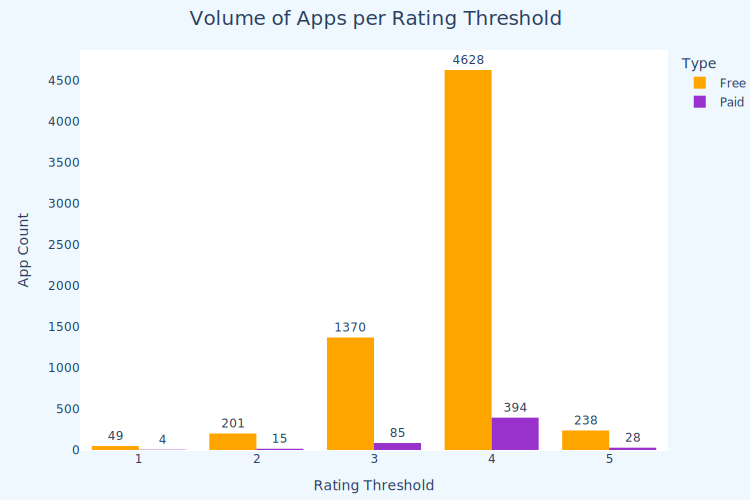

In [12]:
g_hist = px.histogram(data_cleaned,
                      x=data_cleaned['Rating_Threshold'].astype(str),
                      color='Type',
                      color_discrete_map={'Free':'orange', 'Paid':'darkorchid'},
                      barmode = 'group',
                      title = 'Volume of Apps per Rating Threshold',
                      labels={'x':'Rating Threshold'},
                      text_auto = True,
                      width = 750)
g_hist.update_xaxes(categoryorder = 'array',
                    categoryarray = ['1','2','3','4','5'])
g_hist.update_yaxes(showgrid = False)
g_hist.update_traces(textposition = 'outside')
g_hist.update_layout(title = dict(font=dict(size=20), x=0.5),
                     yaxis_title = 'App Count',
                     margin = dict(r=0, t=50, b=50),
                     paper_bgcolor = 'aliceblue',
                     plot_bgcolor = 'white',
                     hovermode = False)
g_hist.show(config = {'staticPlot': True})

In [107]:
free_proportion = (data_cleaned['App'][(data_cleaned['Rating_Threshold'] == 5) & (data_cleaned['Type'] == 'Paid')].count()/data_cleaned['App'][data_cleaned['Rating_Threshold'] == 5].count()).round(3) * 100
print ('Free apps account for {free_proportion}% of 5-star apps.'.format(free_proportion=free_proportion))

Free apps account for 10.5% of 5-star apps.


In [122]:
free_subgroup = data_cleaned.drop(data_cleaned[data_cleaned['Type'] == 'Free'].index)
free_subgroup.groupby(['Rating_Threshold'])[['Price']].mean()

,Price
Rating_Threshold,
1,2.74
2,4.89
3,5.00
4,4.48
5,3.64


## Which Apps Are Largest In Size?

The largest apps on the Play Store don't break 100 mB. This is due to a 100 mB file size limit imposed on developers. However, apps have no minimum limit and can be as small as 0.008 mB (8.5 kB).

There are 14 apps at the maximum size limit, the majority of which are gaming apps.

In [36]:
data_cleaned[['App', 'Size', 'Category']].sort_values('Size', ascending=False).head(10).reset_index(drop=True)

,App,Size,Category
0,Gangster Town: Vice District,100.00,Family
1,The Walking Dead: Our World,100.00,Game
2,Stickman Legends: Shadow Wars,100.00,Game
3,Draft Simulator for FUT 18,100.00,Sports
4,Car Crash III Beam DH Real Damage Simulator 2018,100.00,Game
5,SimCity BuildIt,100.00,Family
6,Miami crime simulator,100.00,Game
7,Ultimate Tennis,100.00,Sports
8,Vi Trainer,100.00,Health & Fitness
9,Hungry Shark Evolution,100.00,Game


In [35]:
data_cleaned[['App', 'Size', 'Category']].sort_values('Size', ascending=True).head(10).reset_index(drop=True).style.format(precision=3)

,App,Size,Category
0,Essential Resources,0.008,Libraries & Demo
1,Market Update Helper,0.011,Libraries & Demo
2,My baby firework (Remove ad),0.014,Family
3,ExDialer PRO Key,0.017,Communication
4,Ad Remove Plugin for App2SD,0.017,Productivity
5,Fill 'er Up,0.018,Travel & Local
6,Morse Code Reader,0.020,Communication
7,Plugin:AOT v5.0,0.022,Business
8,EM Launcher Pro,0.023,Personalization
9,Bixby Button Remapper - bxActions Pro / Coffee,0.024,Tools


In [ ]:
print ('There are', data_cleaned['App'][data_cleaned['Size'] == 100].count(), 'apps at the maximum size.')

There are 14 apps at the maximum size.


In [ ]:
maxsize_subset = data_cleaned.drop(data_cleaned[data_cleaned['Size'] != 100].index)
maxsize_subset[['Category', 'App']].groupby(['Category']).count()

,App
Category,
Family,2
Finance,1
Game,6
Health & Fitness,1
Lifestyle,1
Medical,1
Sports,2


## Which Apps Have The Most Reviews?

Ranking the top apps by number of reviews reveals that apps with the most reviews tend to be free gaming apps. More in-depth analysis on differences between free/paid apps and between app categories will follow in a dedicated section.

In [33]:
data_cleaned[['App', 'Reviews', 'Type', 'Category']].sort_values('Reviews', ascending=False).head(10).reset_index(drop=True)

,App,Reviews,Type,Category
0,Clash of Clans,44881447,Free,Family
1,Subway Surfers,27711703,Free,Game
2,Clash Royale,23125280,Free,Family
3,Candy Crush Saga,22419455,Free,Family
4,UC Browser - Fast Download Private & Secure,17712922,Free,Communication
5,8 Ball Pool,14184910,Free,Sports
6,DU Battery Saver - Battery Charger & Battery Life,13479633,Free,Tools
7,Cache Cleaner-DU Speed Booster (booster & clea...,12759663,Free,Tools
8,Shadow Fight 2,10979062,Free,Game
9,Pou,10483141,Free,Family


## How Many Apps Had Over 1 Billion Installations?

Two apps, Subway Surfers and Google News, reached 1 billion installs. The majority of apps have between 10 thousand and 1 million installs.

In [45]:
data_cleaned[['App', 'Category', 'Rating', 'Reviews', 'Size', 'Type', 'Price', 'Content_Rating'] ][data_cleaned['Installs'] == 1000000000].reset_index(drop=True)

,App,Category,Rating,Reviews,Size,Type,Price,Content_Rating
0,Subway Surfers,Game,4.50,27711703,76.00,Free,0.00,Everyone 10+
1,Google News,News & Magazines,3.90,877635,13.00,Free,0.00,Teen


In [15]:
data_cleaned.groupby('Installs')[['App']].count()

,App
Installs,
1,3
5,9
10,67
50,56
100,296
500,195
1000,670
5000,410
10000,944


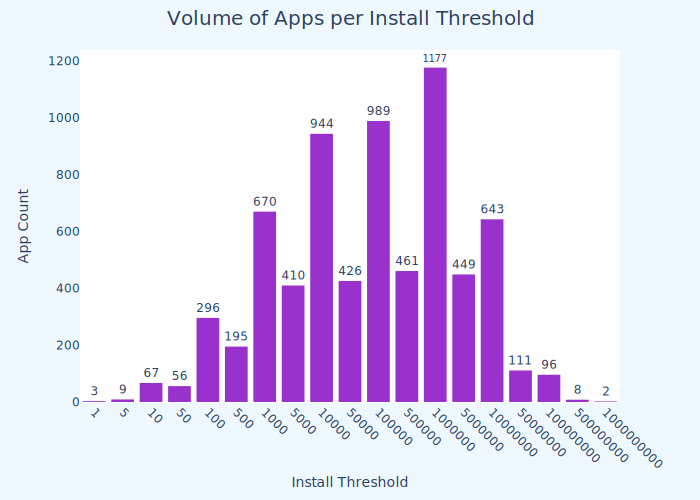

In [20]:
install_thresholds = pd.Series.unique(data_cleaned['Installs'].sort_values().astype(str)).tolist()
hist = px.histogram(data_cleaned,
                    x = data_cleaned['Installs'].astype(str),
                    title = 'Volume of Apps per Install Threshold',
                    labels = {'x': 'Install Threshold'},
                    text_auto = True)
hist.update_xaxes(tickangle=45,
                  categoryarray=install_thresholds)
hist.update_yaxes(showgrid=False)
hist.update_layout(title = dict(font=dict(size=20), x=0.5),
                   yaxis_title = 'App Count',
                   margin = dict(r=80, t=50, b=90),
                   paper_bgcolor = 'aliceblue',
                   plot_bgcolor = 'white',
                   hovermode = False,
                   hoverlabel = dict(bgcolor="white", font_size=14))
hist.update_traces(textposition = 'outside',
                   marker_color ='darkorchid')
hist.show(config = {'staticPlot': True})

## What Are The Most Expensive Apps?

Examining `Price` more closely, the most expensive app costs \$79.99. However, the most expensive apps do not have much popularity in terms of reviews and installs.

An estimate of app revenue, `Gross Revenue`, can be included by multiplying the price of the app and the number of installs.

Among the top 10 highest grossing paid apps, 4 are gaming apps and 3 are family apps. Photography, lifestyle, and medical apps have 1 app respectively in the top 10.


In [42]:
data_cleaned[['App', 'Price', 'Rating', 'Reviews', 'Installs']].sort_values('Price', ascending=False).head(10).reset_index(drop=True)

,App,Price,Rating,Reviews,Installs
0,Vargo Anesthesia Mega App,79.99,4.60,92,1000
1,LTC AS Legal,39.99,4.00,6,100
2,I am Rich Person,37.99,4.20,134,1000
3,A Manual of Acupuncture,33.99,3.50,214,1000
4,PTA Content Master,29.99,4.20,64,1000
5,Golfshot Plus: Golf GPS,29.99,4.10,3387,50000
6,AP Art History Flashcards,29.99,5.00,1,10
7,EMT PASS,29.99,3.40,51,1000
8,"Muscle Premium - Human Anatomy, Kinesiology, B...",24.99,4.20,168,10000
9,Human Anatomy Atlas 2018: Complete 3D Human Body,24.99,4.50,2921,100000


In [45]:
data_cleaned['Gross_Revenue'] = data_cleaned.Installs.mul(data_cleaned.Price)
data_cleaned[['App', 'Gross_Revenue', 'Reviews', 'Rating', 'Category']].sort_values(['Gross_Revenue', 'Reviews', 'Rating'], ascending=False).head(10).reset_index(drop=True)

,App,Gross_Revenue,Reviews,Rating,Category
0,Hitman Sniper,"9,900,000.00",408292,4.60,Game
1,Grand Theft Auto: San Andreas,"6,990,000.00",348962,4.40,Game
2,Facetune - For Free,"5,990,000.00",49553,4.40,Photography
3,Sleep as Android Unlock,"5,990,000.00",23966,4.50,Lifestyle
4,DraStic DS Emulator,"4,990,000.00",87766,4.60,Game
5,Bloons TD 5,"2,990,000.00",190086,4.60,Family
6,Card Wars - Adventure Time,"2,990,000.00",129603,4.30,Family
7,Five Nights at Freddy's,"2,990,000.00",100805,4.60,Game
8,Human Anatomy Atlas 2018: Complete 3D Human Body,"2,499,000.00",2921,4.50,Medical
9,NBA JAM by EA SPORTS???,"2,495,000.00",56444,4.30,Family


## Are There Differences Between Categories?

**Family apps** account for the highest proportion of apps on the Play Store at 22%, with **gaming** and **tools** representing 12% and 9% of the total apps, respectively. The other categories have roughly the same volume of apps.  

However, gaming apps are the most popular apps in terms of installs. Family and Tools apps are second and third in popularity, while Communication apps come in at fourth.

In [16]:
top_category = data_cleaned['Category'].value_counts()
top_category.head()

Family             1529
Game                814
Tools               626
Personalization     276
Medical             266
Name: Category, dtype: int64

In [17]:
top_proportion = top_category/data_cleaned['App'].count()
top_proportion.head()

Family            0.22
Game              0.12
Tools             0.09
Personalization   0.04
Medical           0.04
Name: Category, dtype: float64

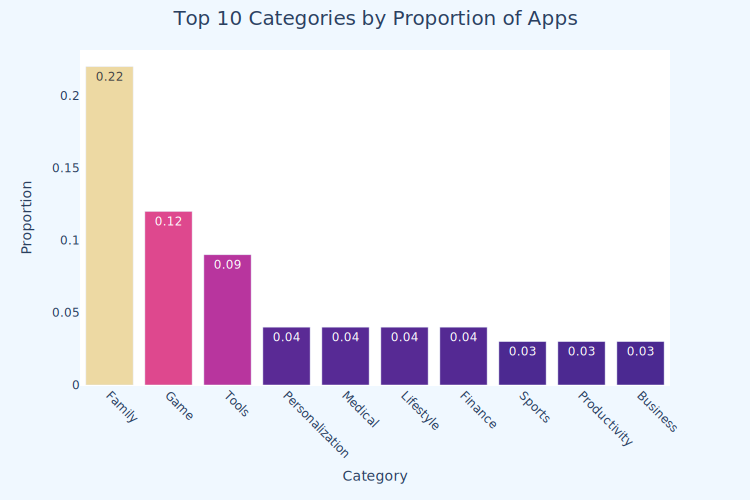

In [18]:
bar = px.bar(x = top_proportion[:10].index,
             y = top_proportion[:10].values.round(2),
             custom_data = [top_category[:10], (top_proportion[:10] * 100).round()],
             color = top_proportion[:10].values,
             color_continuous_scale='agsunset',
             title = 'Top 10 Categories by Proportion of Apps <br><sup>(Hover for more info)</sup>',
             labels = {'x': 'Category', 'y': 'Proportion', 'color': ''},
             text_auto = True,
             width = 750)
bar.update_xaxes(tickangle=45)
bar.update_yaxes(showgrid=False)
bar.update_layout(title = dict(font=dict(size=20), x=0.5),
                  margin = dict(r=80, t=50, b=115),
                  paper_bgcolor = 'aliceblue',
                  plot_bgcolor = 'white',
                  hoverlabel = dict(bgcolor="white", font_size=14))
bar.update_traces(textposition = 'inside',
                  hovertemplate = '<b>%{x} Category</b>' +
                                  '<br></br>' +
                                  'App Count: <b>%{customdata[0]}</b>' +
                                  '<br>Percentage of Play Store: <b>%{customdata[1]}%</br>')
bar.update_coloraxes(showscale=False)
bar.layout.xaxis.fixedrange = True
bar.layout.yaxis.fixedrange = True
bar.show()

In [22]:
category_installs = data_cleaned.groupby('Category')['Installs'].sum().sort_values()
category_installs

Category
Events                 10648400
Beauty                 13416200
Comics                 17431100
Parenting              23566010
Medical                27460176
Auto & Vehicles        43769800
Libraries & Demo       50983000
House & Home           51482000
Dating                 84592410
Art & Design           99233100
Books & Reference     114784155
Weather               129296500
Food & Drink          136467750
Education             145202000
Maps & Navigation     174015560
Travel & Local        228638300
Finance               244524300
Business              381282920
Lifestyle             404388120
Entertainment         522960000
Social                558240475
Shopping              710731540
Health & Fitness      756456220
Video Players         866762200
Personalization       895142930
Sports               1006311465
News & Magazines     1190900550
Productivity         1291302080
Photography          1493893130
Communication        1818915530
Tools                2880053500

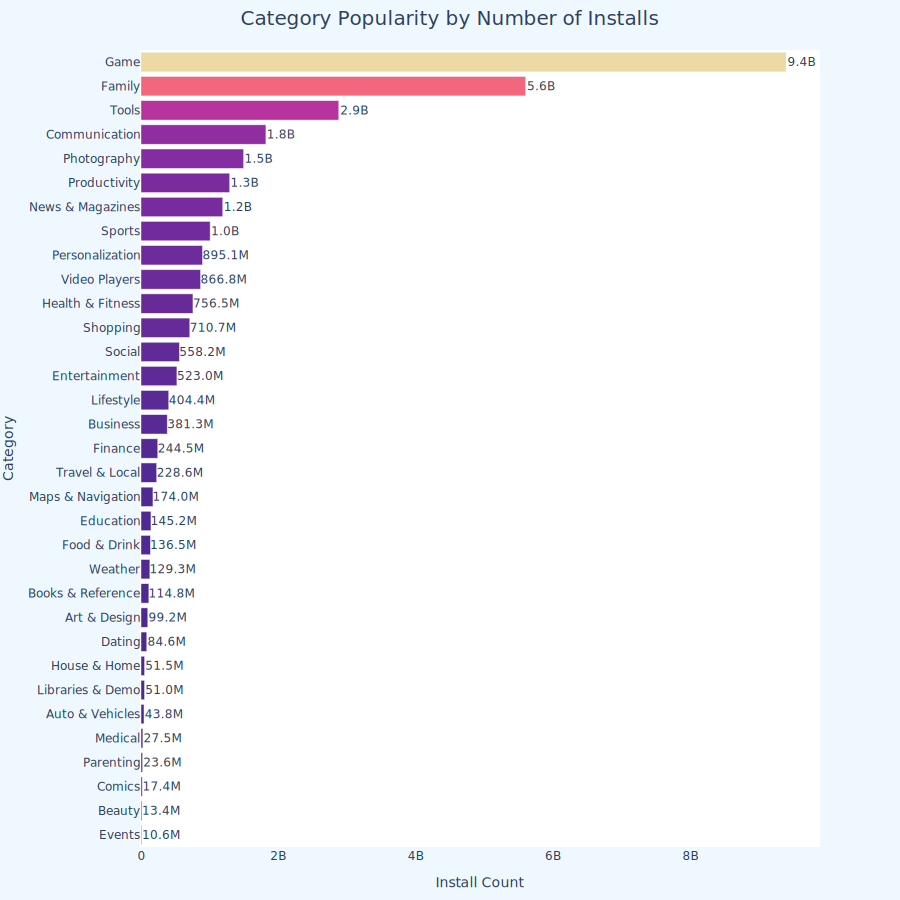

In [30]:
#custom plotly bar labels to replace the default 'Giga' and 'Mega' with 'Billion' and 'Million'
customtext = category_installs.copy()
for x in range(len(customtext.values)):
  if customtext[x] < 1000000000:
    customtext[x] = str(round((customtext[x] / 1000000), 1)) + 'M'
  else:
    customtext[x] = str(round((customtext[x] / 1000000000), 1)) + 'B'

h_bar = px.bar(x = category_installs.values,
               y = category_installs.index,
               color = category_installs.values,
               color_continuous_scale='agsunset',
               orientation='h',
               text = [x for x in customtext],
               title='Category Popularity by Number of Installs',
               labels = {'x': 'Install Count', 'y': 'Category', 'color': ''},
               height = 900,
               width = 900)
h_bar.update_yaxes(showgrid=False)
h_bar.update_layout(title = dict(font=dict(size=20), x=0.5),
                    margin = dict(l=90, r=80, t=50, b=50),
                    paper_bgcolor = 'aliceblue',
                    plot_bgcolor = 'white',
                    hoverlabel = dict(bgcolor="white", font_size=14))
h_bar.update_traces(textposition = 'outside')
h_bar.update_coloraxes(showscale = False)
h_bar.show(config = {'staticPlot': True})

## What Is The Relationship Between App Volume And Installs?

Popular apps (those with high install numbers) tend to have more developers creating apps for them. Apps in the `Game`, `Family`, and `Tool` categories also have the highest install counts, which is consistent with their popularity.

Given a Pearson correlation coefficient of 0.81, there is a strong positive relationship between app category popularity and the number of apps within the category.

In [31]:
category_info = data_cleaned.groupby('Category').agg({'App':'count', 'Installs':'sum'})
category_info.sort_values('Installs', ascending=False).head()

,App,Installs
Category,,
Game,814,9392352717
Family,1529,5599786480
Tools,626,2880053500
Communication,189,1818915530
Photography,204,1493893130


In [37]:
pearson = category_info['App'].corr(category_info['Installs']).round(2)
print ('The Pearson correlation coefficient is {pearson}.'.format(pearson = pearson))

The Pearson correlation coefficient is 0.81.


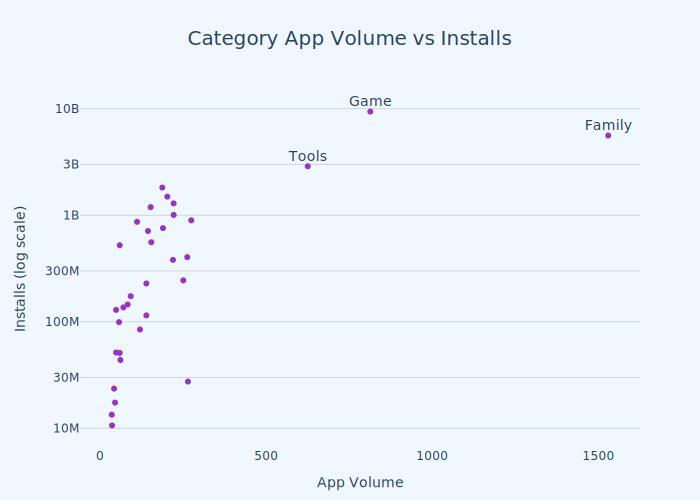

In [32]:
scatter = px.scatter(x = category_info['App'],
                     y = category_info['Installs'],
                     custom_data = [category_info.index],
                     #text = category_info.index,
                     title = 'Category App Volume vs Installs <br><sup>(Click and drag to zoom for more info, double click to reset zoom)</sup></br>',
                     labels = {'x': 'App Volume', 'y': 'Installs (log scale)'},
                     )
scatter.update_layout(title = dict(font=dict(size=20), x=0.5),
                      paper_bgcolor = 'aliceblue',
                      plot_bgcolor = 'aliceblue',
                      hoverlabel = dict(bgcolor='white', font_size=14),
                      margin = dict(l=80, r=60, t=90, b=50),
                      yaxis = dict(type='log'))
scatter.update_traces(marker_color ='darkorchid',
                      hovertemplate = '<b>%{customdata[0]} Category</b>' +
                                  '<br></br>' +
                                  'App Volume: <b>%{x}</b>' +
                                  '<br>Install Count: <b>%{y}</br>')
scatter.update_xaxes(showspikes = True,
                     spikecolor = 'orange',
                     spikethickness = 2,
                     showgrid = False,
                     zeroline = False)
scatter.update_yaxes(showspikes = True,
                     spikecolor = 'orange',
                     spikethickness = 2,
                     showgrid = True,
                     gridcolor = 'lightgrey',
                     tickmode = 'array',
                     tickvals = [10000000, 30000000, 100000000, 300000000, 1000000000, 3000000000, 10000000000])
scatter.add_annotation(x = category_info.loc['Family','App'],
                       y = np.log(category_info.loc['Family','Installs']) / np.log(10) + 0.1,
                       text = 'Family',
                       showarrow = False,
                       font = dict(size=14))
scatter.add_annotation(x = category_info.loc['Game','App'],
                       y = np.log(category_info.loc['Game','Installs']) / np.log(10) + 0.1,
                       text = 'Game',
                       showarrow = False,
                       font = dict(size=14))
scatter.add_annotation(x = category_info.loc['Tools','App'],
                       y = np.log(category_info.loc['Tools','Installs']) / np.log(10) + 0.1,
                       text = 'Tools',
                       showarrow = False,
                       font = dict(size=14))
scatter.show()

## What are the most popular genres?


In [58]:
stack = data_cleaned.Genres.str.split(';', expand=True).stack()
#stack.groupby(['Category', 'Genres'])['App'].count()
print (stack)
#stack.value_counts()

1695   0    Libraries & Demo
1698   0              Action
1699   0              Action
1700   0        Role Playing
1701   0        Role Playing
                  ...       
10832  0               Tools
10834  0               Tools
10836  0           Education
10837  0           Education
10838  0       Communication
Length: 7347, dtype: object


In [39]:
bar = px.bar(x = num_genres.index[:15],
             y = num_genres.values[:15],
             title='Top Genres by Number of Apps',
             hover_name=num_genres.index[:15],
             color=num_genres.values[:15],
             color_continuous_scale='agsunset')

bar.update_layout(xaxis_title='Genre',
                  yaxis_title='Number of Apps',
                  coloraxis_showscale=False)
bar.show()

NameError: ignored

## What Are The Differences Between Paid and Free Apps?

Paid apps cost \$15.24 on average. They are also rated slighly higher than free apps on average. However, they have far less popularity, as indicated by their reviews and installs versus free apps.

Free apps also dominate the Play Store in each category. Auto/Vehicles, Libraries/Demo, Beauty, Comics, Events, and House/Home apps have no paid offerings.

In [ ]:
data_cleaned.groupby('Type')[['Price', 'Rating', 'Reviews', 'Installs']].mean(numeric_only=True)

,Price,Rating,Reviews,Installs
Type,,,,
Free,0.00,4.15,"156,151.80","4,829,307.88"
Paid,15.24,4.24,"6,867.77","78,223.26"


In [34]:
free_paid = data_cleaned.groupby(['Category', 'Type'])[['App']].count().reset_index()
free_paid.head()

,Category,Type,App
0,Art & Design,Free,56
1,Art & Design,Paid,3
2,Auto & Vehicles,Free,63
3,Beauty,Free,37
4,Books & Reference,Free,134


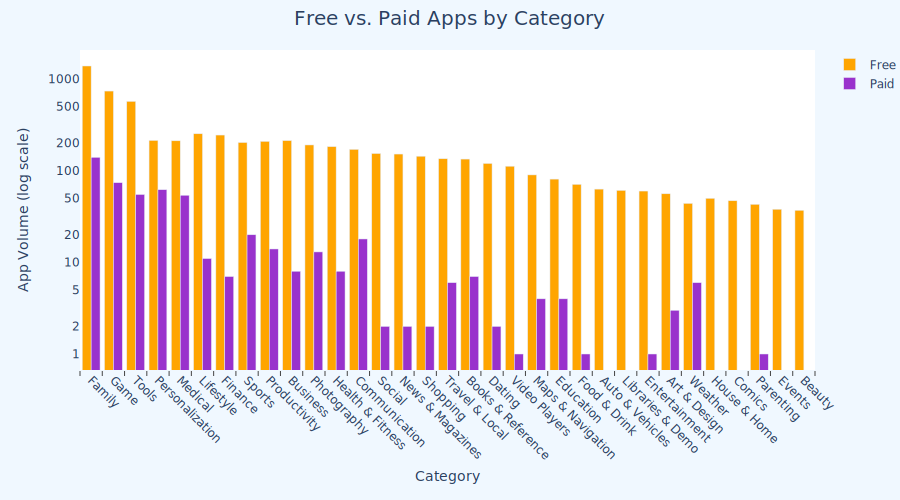

In [36]:
multi_bar = px.bar(x = free_paid['Category'],
                   y = free_paid['App'],
                   color = free_paid['Type'],
                   color_discrete_map = {'Free':'orange', 'Paid':'darkorchid'},
                   title = 'Free vs. Paid Apps by Category <br><sup>(Hover for more info, click and drag to zoom)</sup><br>',
                   labels = {'x': 'Category', 'y': 'App Volume (log scale)', 'color': ''},
                   custom_data = [free_paid['Type']],
                   barmode = 'group',
                   width = 900)
multi_bar.update_layout(title = dict(font=dict(size=20), x=0.5),
                        paper_bgcolor = 'aliceblue',
                        plot_bgcolor = 'white',
                        hoverlabel = dict( font_size=14),
                        margin = dict(r=0, t=50, b=130),
                        xaxis = {'categoryorder':'total descending'},
                        yaxis = dict(type='log'))
multi_bar.update_traces(hovertemplate = '<b>%{customdata[0]} %{x} Apps</b>' +
                                        '<br></br>' +
                                        'App Volume: <b>%{y}<extra></extra>')
multi_bar.update_xaxes(tickangle = 45,
                       ticks = 'outside',
                       tickson = 'boundaries')
multi_bar.update_yaxes(tickmode = 'array',
                       tickvals = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
multi_bar.show()

## How Much Do Developers Charge?

While the overall median price for an app is \$2.99, median prices can range from \$0.99 to \$6.99 across categories. Dating apps have the highest median price at \$7.49 while video players and social apps have the lowest median price at \$0.99.

Medical apps are the most variable, with the largest range of prices from \$0.99 to \$24.99.

The family category has the most outliers. However the largest outlier is in the medical category at \$79.99.

In [46]:
paid_subset = data_cleaned[data_cleaned['Type'] == 'Paid']
paid_subset.Price.median()

2.99

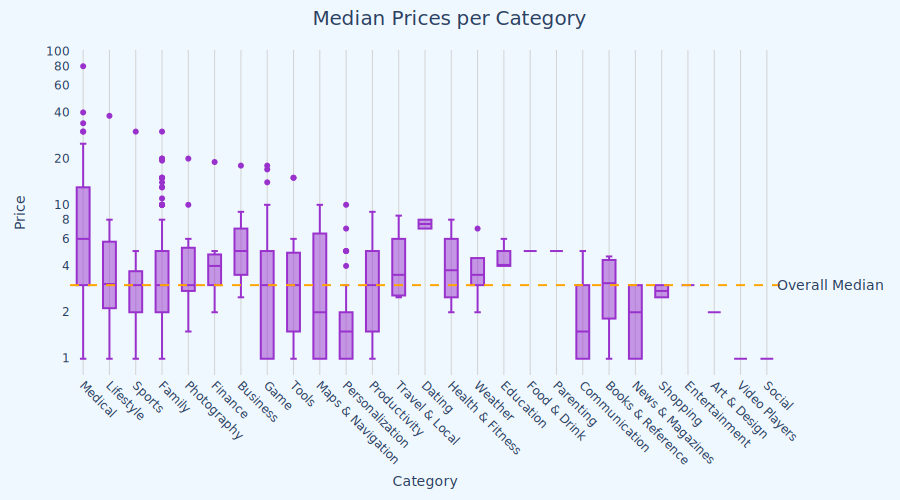

In [41]:
box = px.box(paid_subset,
             x = 'Category',
             y = 'Price',
             title = 'Median Prices per Category <br><sup>(Hover for more info, click and drag to zoom)</sup></br>',
             labels = {'x': 'Category', 'y': 'App Price (log scale)'})
box.update_layout(title = dict(font=dict(size=20), x=0.5),
                      paper_bgcolor = 'aliceblue',
                      plot_bgcolor = 'aliceblue',
                      hoverlabel = dict(bgcolor='white', font_size=14),
                      margin = dict(l=70, r=120, t=50, b=125),
                      xaxis = {'categoryorder':'max descending'},
                      yaxis = dict(type = 'log'),
                      width = 900
                      )
box.update_traces(marker_color ='darkorchid',
                  hovertemplate = '<b>%{x} Category Outlier</b>' +
                                  '<br></br>' +
                                  'App Price: <b>$%{y}</b>')
box.update_xaxes(tickangle = 45,
                 showgrid = True,
                 gridcolor = 'lightgrey')
box.update_yaxes(showgrid = False,
                 tickmode = 'array',
                 tickvals = [1, 2, 4, 6, 8, 10, 20, 40, 60, 80, 100])
box.add_hline(y = paid_subset.Price.median(),
              line_color = 'orange',
              line_dash = 'dash')
box.add_annotation(xref = 'paper',
                   x = 1.14,
                   y = np.log(paid_subset.Price.median()) / np.log(10),
                   text = 'Overall Median',
                   showarrow = False,
                   font = dict(size=14))
box.show()

## How Much Do Developers Earn?


Developers for paid apps have earned a median gross revenue of \$9,950 on app purchases. Apps in the `Game` category have the largest distribution of revenue while also containing the highest earners overall. This causes the distribution to skew towards higher numbers.  

Game apps

In [64]:
paid_subset.Gross_Revenue.median()

9950.0

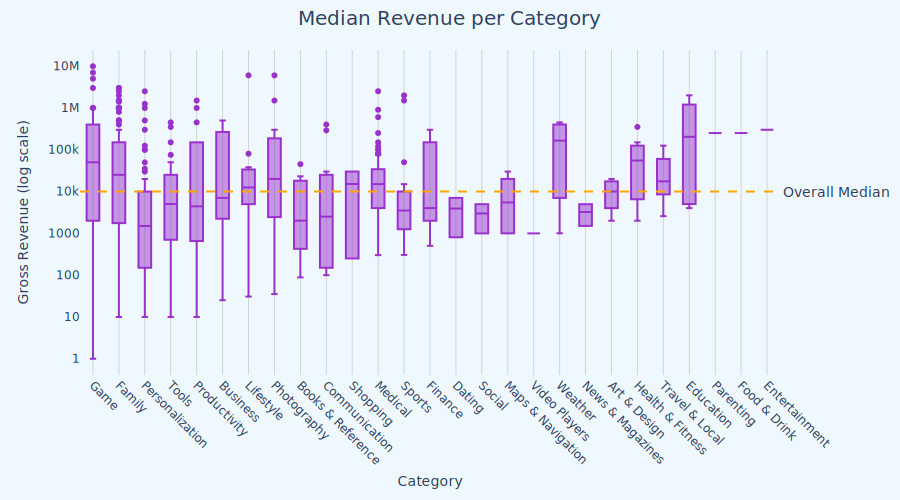

In [47]:
box2 = px.box(x = paid_subset['Category'],
              y = paid_subset['Gross_Revenue'],
              title ='Median Revenue per Category',
              labels = {'x': 'Category', 'y': 'Gross Revenue (log scale)'})
box2.update_layout(title = dict(font=dict(size=20), x=0.5),
                   paper_bgcolor = 'aliceblue',
                   plot_bgcolor = 'aliceblue',
                   hoverlabel = dict(bgcolor='white', font_size=14),
                   margin = dict(r=120, t=50, b=125),
                   xaxis = {'categoryorder':'min ascending'},
                   yaxis = dict(type='log'),
                   width = 900
                   )
box2.update_traces(marker_color ='darkorchid',
                   #hoverinfo = 'skip',
                   #hovertemplate = None
                   #hovertemplate = '<b>%{x} Outlier</b>' +
                   #                '<br></br>' +
                   #                'Gross Revenue: <b>$%{y}</b>'
                   )
box2.update_xaxes(tickangle = 45,
                  showgrid = True,
                  gridcolor = 'lightgrey',)
box2.update_yaxes(showgrid = False)
box2.add_hline(y = paid_subset.Gross_Revenue.median(),
               line_color = 'orange',
               line_dash = 'dash'
               )
box2.add_annotation(xref = 'paper',
                   x = 1.15,
                   y = np.log(paid_subset.Gross_Revenue.median()) / np.log(10),
                   text = 'Overall Median',
                   showarrow = False,
                   font = dict(size=14))
box2.show()

## Visualing Content Ratings

Apps intended for users of all ages are the most popular in the Play Store. The 'Everyone' category caters to a very wide audience, making it a natural choice for developers looking to maximize their potential user base.

Apps rated `Everyone 10+` have less representation than apps rated `Teen` and `Mature 17+`. One explanation might be that content complexity and themes suitable for the 'Everyone 10+' category may overlap more with the 'Everyone' category, leading to a preference for developers to aim for the broader 'Everyone' rating.

In [49]:
ratings = data_cleaned.Content_Rating.value_counts()
ratings.head()

Everyone           5668
Teen                778
Mature 17+          304
Everyone 10+        259
Adults only 18+       2
Name: Content_Rating, dtype: int64

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:138: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



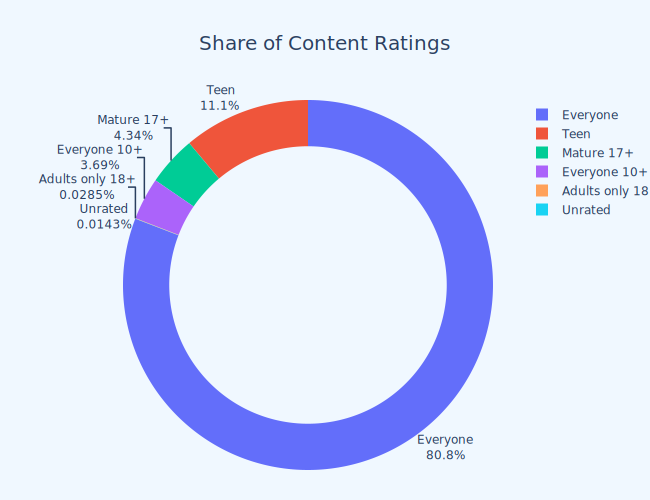

In [50]:
donut = px.pie(labels = ratings.index,
             values = ratings.values,
             names = ratings.index,
             title = 'Share of Content Ratings',
             hole = 0.75,
             width = 650)
donut.update_traces(textposition = 'outside',
                    textinfo = 'percent+label')
donut.update_layout(title = dict(font=dict(size=20), x=0.5),
                    paper_bgcolor = 'aliceblue',
                    plot_bgcolor = 'aliceblue',
                    margin = dict(l=0, r=0, t=100, b=30))
donut.show()

#End Notebook